# Olist E-Commerce Website Data Analysis 

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score, confusion_matrix
import datetime
import random

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
sns.set()
pd.options.display.max_columns = 100

# Fonctions d'automatisation

In [2]:
# take df, make copy, show info() and return the dataframe
def copy_get_info_df(df):
    new_df = df.copy()
    new_df.info()
    print('total missing values : ', new_df.insull().sum())
    print('the shape is : ', new_df.shape)
    return new_df
#-------------------------------------------------------------------
# pass list of dataframes and get all the infos, shape, missing values at once 
def get_all_df_info(dataframes):
    df_names = ['customer data :','order items : ','order payments : ','order reviews :','orders datasets : ','products datasets : ','sellers : ','product translation :']
    for name,df in zip(df_names,dataframes):
        print('INFORMATION ABOUT', name,'\n')
        new_df = df.copy()
        df.info()
        print('\n Total missing values:\n', new_df.isnull().sum(),'\n')
        print('Shape : ', new_df.shape)
        print('\n')
        print('-----------------------------------------------------')
#---------------------------------------------------------------------
        
        

### Loading the Data

In [3]:
# Loading all datasets : 
customers_dataset_df = pd.read_csv('./brazilian-ecommerce/olist_customers_dataset.csv')
order_items_df = pd.read_csv('./brazilian-ecommerce/olist_order_items_dataset.csv')
order_payments_dataset_df = pd.read_csv('./brazilian-ecommerce/olist_order_payments_dataset.csv')
order_reviews_dataset_df = pd.read_csv('./brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders_dataset_df = pd.read_csv('./brazilian-ecommerce/olist_orders_dataset.csv')
products_dataset_df = pd.read_csv('./brazilian-ecommerce/olist_products_dataset.csv')
sellers_dataset_df = pd.read_csv('./brazilian-ecommerce/olist_sellers_dataset.csv')
product_category_name_translation_df = pd.read_csv('./brazilian-ecommerce/product_category_name_translation.csv')

#datasets names:
datasets = [customers_dataset_df, order_items_df, order_payments_dataset_df, order_reviews_dataset_df,orders_dataset_df,products_dataset_df, sellers_dataset_df, ]

In [4]:
# getting informations about every datasets to get the first intuition:
get_all_df_info(datasets)

INFORMATION ABOUT customer data : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB

 Total missing values:
 customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64 

Shape :  (99441, 5)


-----------------------------------------------------
INFORMATION ABOUT order items :  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column      

#### order_reviews_dataset

In [5]:
# review_comment_title and review_comment_message fields are empty which is fine, we will not be using them in out analysis so
# we will drop the columns in addition to review_creation_date and review_answer_timestamp columns
order_reviews_dataset_df_clean = order_reviews_dataset_df.copy()

# we drop also review creation date and answer date we dont need those
order_reviews_dataset_df_clean.drop(columns = ['review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp'], inplace = True)

In [6]:
order_reviews_dataset_df_clean.head()
order_reviews_dataset_df_clean.info()
order_reviews_dataset_df_clean.describe()

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   review_id     100000 non-null  object
 1   order_id      100000 non-null  object
 2   review_score  100000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


,review_score
count,100000.000000
mean,4.070890
std,1.359663
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


#### orders_dataset

In [7]:
# 1.we will be assessing if our estimation on the order_estimated_delivery_date is correct most of the time or not, so in this case
# we will create a df that has only the timestamps and dates and we will be dropping this nan values to do so, that is so we 
# do not loose data for other operations from the original dataframe.
# 2. we need to change  the data type of the dates to datetime.
orders_dataset_df_clean = orders_dataset_df.copy()
order_datetime_list = ['order_purchase_timestamp', 'order_approved_at',\
                       'order_delivered_carrier_date', 'order_delivered_customer_date',\
                       'order_estimated_delivery_date']


orders_dataset_df_clean[order_datetime_list] = orders_dataset_df_clean[order_datetime_list].apply(pd.to_datetime, errors = 'coerce')
orders_dataset_df_clean.head()

# so now we have the datetime type
orders_dataset_df_clean.info()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [8]:
# checking valid values for order_status
orders_dataset_df_clean.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [9]:
# checking if for the delivered items we have all the timings, the invoiced only can have nan values it is fine for the dates variables.
# we can see that we still have missing dates for already delivered orders, we can investigate closely in the company to see why we are missing these dates.

orders_dataset_df_clean.query("order_status in 'delivered'").isnull().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [10]:
# getting the indexes of the columns that have a delivered order_status and a null order_approved_at because it does not make sense
delivered_and_not_approved_indexes = orders_dataset_df_clean[orders_dataset_df_clean['order_approved_at'].isnull()].query("order_status in 'delivered'").index

In [11]:
orders_dataset_df_clean.drop(inplace = True, index = delivered_and_not_approved_indexes)

In [12]:
orders_dataset_df_clean.query("order_status in 'delivered'").isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     2
order_delivered_customer_date    8
order_estimated_delivery_date    0
dtype: int64

#### products_dataset

In [13]:
#clean df:
products_dataset_df_clean = products_dataset_df.copy()

# we will be dropping the rows that have missing product_category_name, product_name_lenght, product_description_lenght, product_photos_qty
# which are 610 rows of 32951
products_dataset_df_clean[products_dataset_df_clean['product_category_name'].isnull()].shape
null_products_indexes = products_dataset_df_clean[products_dataset_df_clean['product_category_name'].isnull()].index
products_dataset_df_clean.drop(inplace = True, index = null_products_indexes)

(610, 9)

In [14]:
# 1 row missing dimensions, we will drop it also since it has negligible effect on our analysis
products_dataset_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32341 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32341 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


In [15]:
additional_products_missing_g_indexes = products_dataset_df_clean[products_dataset_df_clean['product_weight_g'].isnull()].index

In [16]:
products_dataset_df_clean.drop(inplace = True, index = additional_products_missing_g_indexes)

In [17]:
products_dataset_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32340 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32340 non-null  object 
 1   product_category_name       32340 non-null  object 
 2   product_name_lenght         32340 non-null  float64
 3   product_description_lenght  32340 non-null  float64
 4   product_photos_qty          32340 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


In [18]:
products_dataset_df_clean.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2.188961,2276.956586,30.854545,16.958813,23.208596
std,10.245699,635.124831,1.736787,4279.291845,16.955965,13.636115,12.078762
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


#### sellers_dataset

In [19]:
# make copy to rename it and use it safely
sellers_dataset_df_clean = sellers_dataset_df.copy()

## Create Master Dataframe

In [20]:
# creating a master dataframe, that has all the clean dataframes to get more insights when we want to visualize, model and predict

customers_dataset_df_clean = customers_dataset_df.copy()
order_payments_dataset_df_clean = order_payments_dataset_df.copy()
order_items_df_clean = order_items_df.copy()

master_df = orders_dataset_df_clean.copy()
master_df = master_df.merge(customers_dataset_df_clean, on='customer_id', indicator=True)

In [21]:
master_df = master_df.merge(order_reviews_dataset_df_clean, on='order_id')

In [22]:
master_df = master_df.merge(order_payments_dataset_df_clean, on='order_id')

In [23]:
master_df = master_df.merge(order_items_df_clean, on = 'order_id')

In [24]:
master_df = master_df.merge(products_dataset_df_clean, on = 'product_id')

In [25]:
master_df = master_df.merge(sellers_dataset_df_clean, on = 'seller_id')

In [26]:
master_df.shape

(116591, 36)

# Exploratory Data Visualization

#### In this section we will be answering inquiries using visualizations of data insights using univariable, bivariable and multivariable plots

In [27]:
master_df.shape

(116591, 36)

In [28]:
# we only have two columns having null values, order_delivered_carrier_date and order_delivered_customer_date  
master_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date     1215
order_delivered_customer_date    2517
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
_merge                              0
review_id                           0
review_score                        0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name               0
product_name

<Figure size 864x720 with 0 Axes>

Text(0.5, 1, 'Corrélations entres les features')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 <a list of 16 Text xticklabel objects>)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 <a list of 16 Text yticklabel objects>)

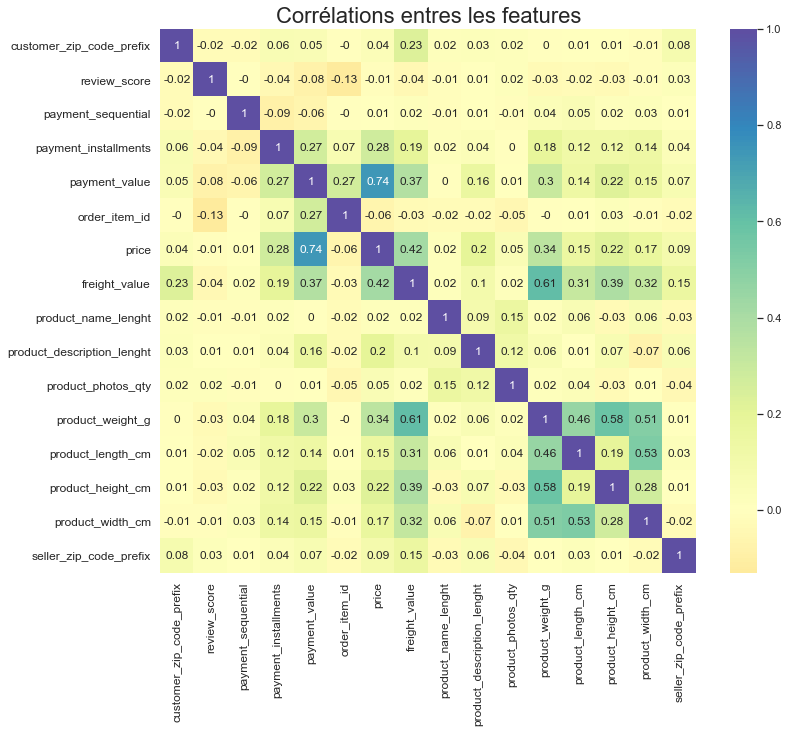

In [29]:
# Heatmap to see correaltions between numerical features
plt.figure(figsize=(12,10))
sns.heatmap(master_df.corr().round(2), xticklabels=master_df.corr().columns, yticklabels=master_df.corr().columns, cmap='Spectral', center=0, annot=True)

plt.title('Corrélations entres les features', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<Figure size 864x720 with 0 Axes>

Text(0.5, 1, 'corrélations simplifié')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 <a list of 16 Text xticklabel objects>)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]),
 <a list of 16 Text yticklabel objects>)

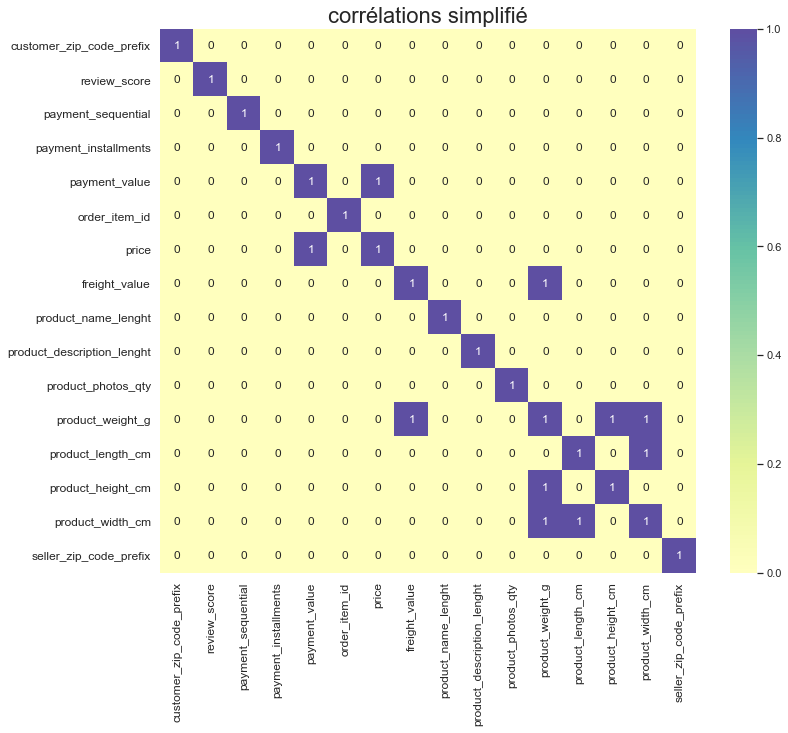

In [30]:
# I prefer round all correlations > 0.5 and make them = 1 so we can identify more clearely what is going on 
corr_df = master_df.corr().round(2)
plt.figure(figsize=(12,10))
sns.heatmap(abs(corr_df)>0.5 , xticklabels=master_df.corr().columns, yticklabels=master_df.corr().columns, cmap='Spectral', center=0, annot=True)

plt.title('corrélations simplifié', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<Figure size 1008x576 with 0 Axes>

(0, 30000)

Text(0.5, 1.0, 'Correlation entre le poids du produit et la valeur Fret')

Text(0.5, 0, 'Product Weight')

Text(0, 0.5, 'Freight Value')

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 <a list of 7 Text xticklabel objects>)

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 <a list of 7 Text yticklabel objects>)

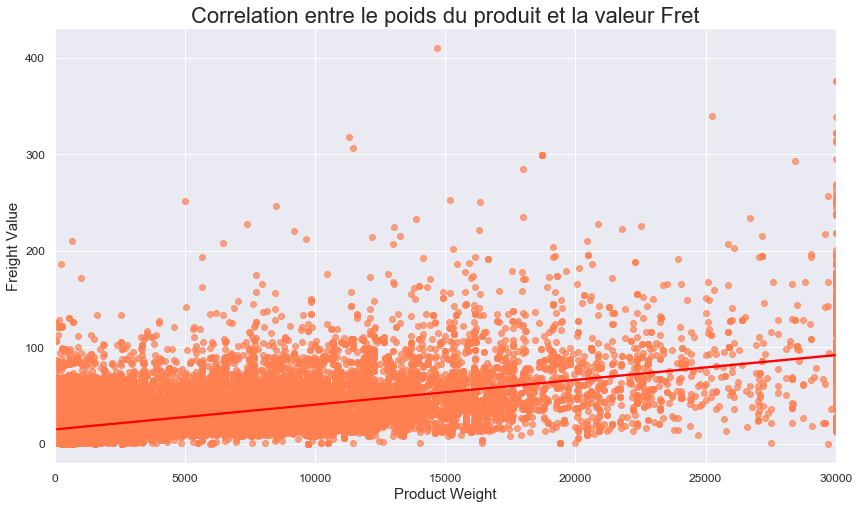

In [31]:
# plot to see correlation between product weight and fret value
plt.figure(figsize=(14,8))

sns.regplot(x=master_df['product_weight_g'], y=master_df['freight_value'], scatter_kws={'alpha':0.7, 'color':'coral'},\
           line_kws={'color':'red'});

plt.xlim(0, 30000)

plt.title('Correlation entre le poids du produit et la valeur Fret', fontsize=22)
plt.xlabel('Product Weight'.title(), fontsize=15)
plt.ylabel('Freight Value'.title(), fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

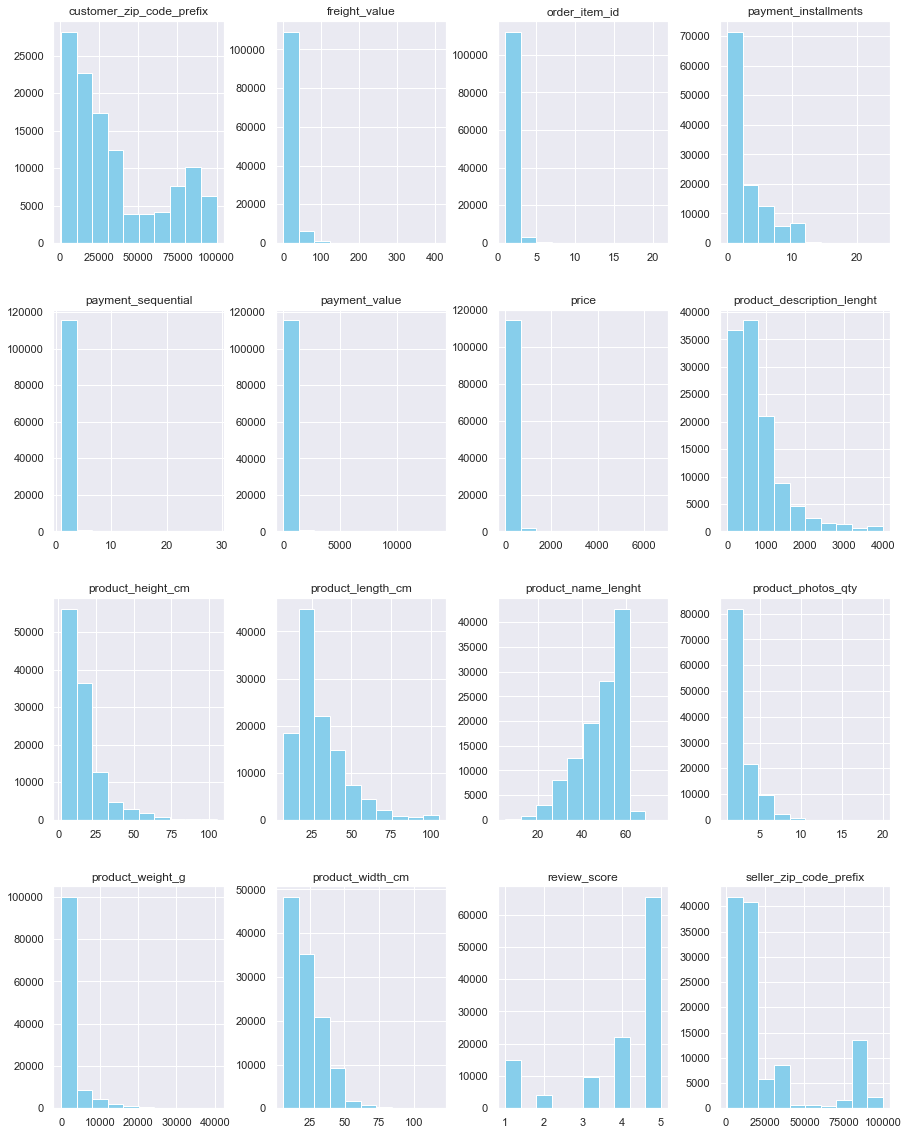

In [32]:
# Distributions for some features
master_df.hist(figsize=(15,20), color='skyblue');

## Univariable Plots

* Type de payements 
* Range des prix de payement 
* Villes qui achetent le plus 
* fréquence d'achat par categorie de produit

In [33]:
# simple groupby to use for ploting payment type
payment_type_count_plot_df = master_df[['payment_type','customer_id']].groupby(['customer_id', 'payment_type']).count().reset_index()

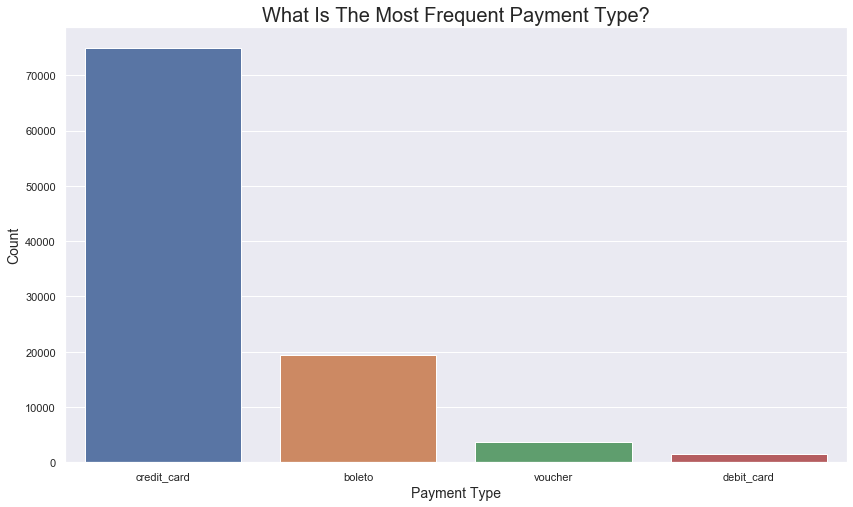

In [34]:
# barplot to see most used payment type

plt.figure(figsize=(14,8))

sns.countplot(payment_type_count_plot_df['payment_type']);

plt.title('What is the most frequent payment type?'.title() , fontsize=20);
plt.ylabel('count'.title(), fontsize=14);
plt.xlabel('payment type'.title(), fontsize=14);

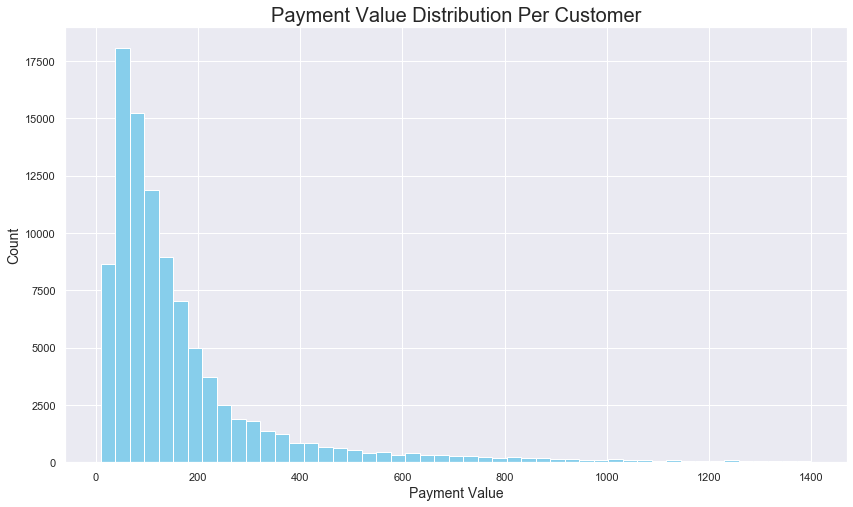

In [35]:
# Payement value frequency

plt.figure(figsize=(14,8))

# we use .sum() because we have the same clients sometimes so we avoid noise and confusion
min_order_payment_value = min(master_df.groupby('customer_id').sum().reset_index()['payment_value'])
max_order_payment_value = max(master_df.groupby('customer_id').sum().reset_index()['payment_value'])

# plot the payment value distribution per customer
bins= np.linspace(start=min_order_payment_value, stop=1400, num=50)
plt.hist(x=(master_df.groupby('customer_id').sum().reset_index()['payment_value']), bins=bins,color='skyblue');

plt.title('payment value distribution per customer'.title() , fontsize=20);
plt.ylabel('count'.title(), fontsize=14, rotation=90);
plt.xlabel('payment value'.title(), fontsize=14);


In [36]:
# simple groupby to use for visualization
customer_state_count_df = master_df.groupby(['customer_id','customer_state']).count().reset_index()

<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Most Frequent Customer State')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Customer State')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text xticklabel objects>)

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000., 45000.]),
 <a list of 10 Text yticklabel objects>)

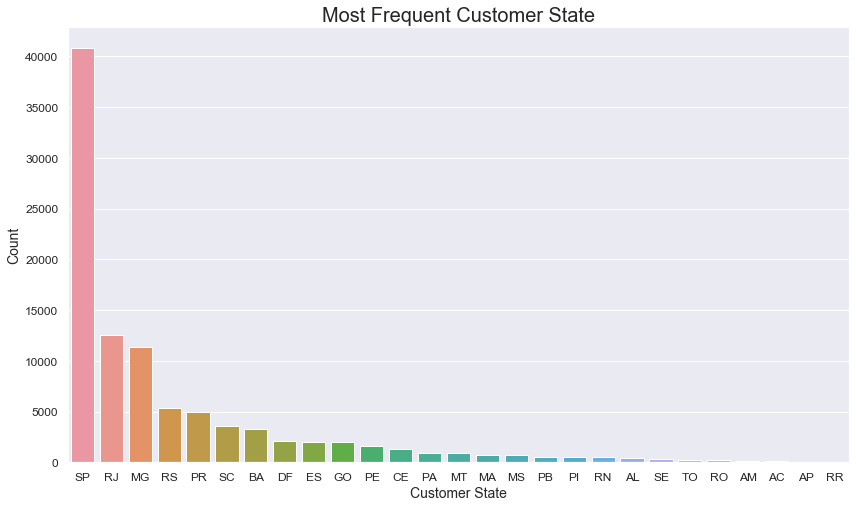

In [37]:
# visualizing the most frequent customer state
plt.figure(figsize=(14,8))
sns.countplot(customer_state_count_df.customer_state, order=customers_dataset_df.customer_state.value_counts().index);

plt.title('Most frequent customer state'.title(), fontsize=20);
plt.ylabel('count'.title(), fontsize=14);
plt.xlabel('customer state'.title(), fontsize=14);

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [38]:
# adding the translated product name category to the data_frame to use it in the following plots.
master_df_with_product_categories = master_df.merge(product_category_name_translation_df, how='left', on='product_category_name');

<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Most In Demand Product Category')

Text(0, 0.5, 'Count')

Text(0.5, 0, 'Product Category')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70]),
 <a list of 71 Text xticklabel objects>)

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.]),
 <a list of 8 Text yticklabel objects>)

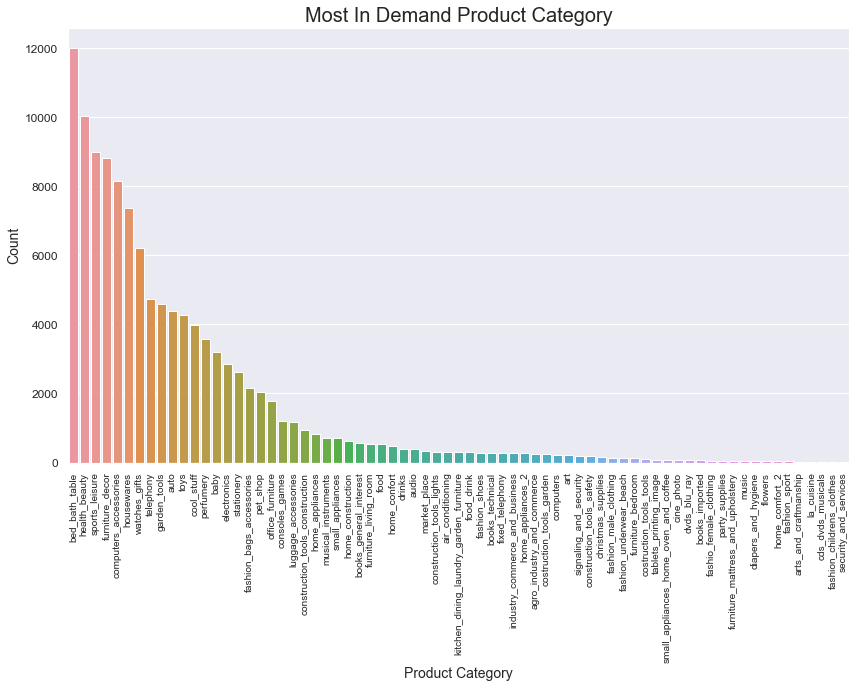

In [39]:
# barplot to visualize the most in demand product category
plt.figure(figsize=(14,8))

sns.countplot(master_df_with_product_categories.product_category_name_english,#
              order=master_df_with_product_categories.product_category_name_english.value_counts().index)

plt.title('Most in demand product category'.title(), fontsize=20);
plt.ylabel('count'.title(), fontsize=14);
plt.xlabel('product category'.title(), fontsize=14);

plt.xticks(rotation=90, fontsize=10);
plt.yticks(fontsize=12)
plt.show()

## Bivariable plots

* Mean score vs products category (Bar plot)
* Mean score vs city (Bar plot)
* Order Price vs Freight Price (Scatter plot)

In [40]:
# groupby product categorie to see their average review scores
mean_score_vs_cat_df = master_df_with_product_categories.groupby(['product_category_name_english']).mean()['review_score'].reset_index()
mean_score_vs_cat_df

,product_category_name_english,review_score
0,agro_industry_and_commerce,4.150794
1,air_conditioning,3.920530
2,art,3.917808
3,arts_and_craftmanship,4.125000
4,audio,3.824147
...,...,...
66,stationery,4.176381
67,tablets_printing_image,4.045977
68,telephony,3.938188
69,toys,4.142490


<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Most Highly Rated Product Category')

Text(0, 0.5, 'Average Review Score')

Text(0.5, 0, 'Product Category')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70]),
 <a list of 71 Text xticklabel objects>)

(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text yticklabel objects>)

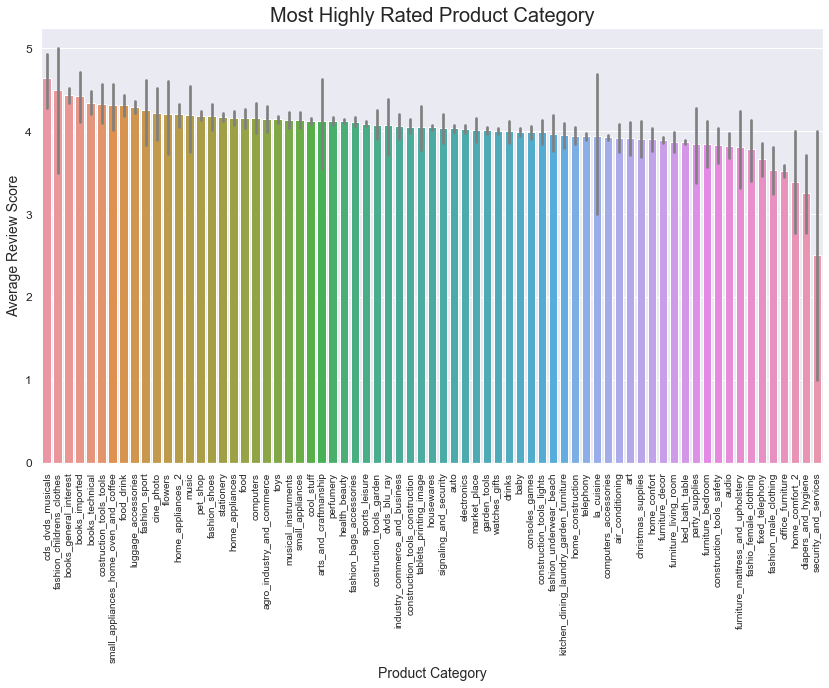

In [41]:
# The on average the best product category rating wise is that of cds_dvds_musicals, and the securit_and_services seems to have
# the lowest rating.

plt.figure(figsize=(14,8))

sns.barplot(data = master_df_with_product_categories, x='product_category_name_english', y='review_score',
            order = mean_score_vs_cat_df.sort_values('review_score', ascending=False)['product_category_name_english'].values
            ,errcolor = 'grey')

plt.title('Most highly rated product category'.title(), fontsize=20);
plt.ylabel('Average Review Score'.title(), fontsize=14);
plt.xlabel('Product Category'.title(), fontsize=14);

plt.xticks(rotation=90, fontsize= 10);
plt.yticks(fontsize=12)
plt.show()

<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Best Reviews By States')

Text(0, 0.5, 'Average Review Score')

Text(0.5, 0, 'Customer State')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text xticklabel objects>)

(array([0., 1., 2., 3., 4., 5.]), <a list of 6 Text yticklabel objects>)

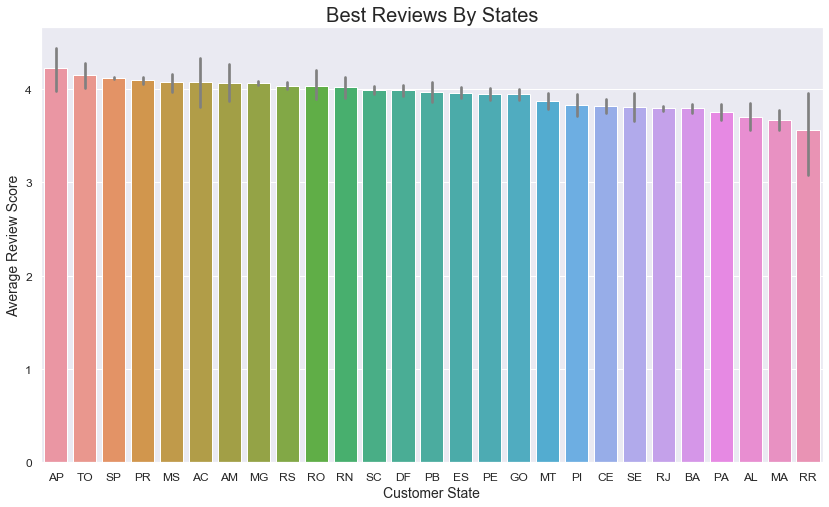

In [42]:
# barplot to visualize the nicest state

plt.figure(figsize=(14,8))

sns.barplot(data = master_df_with_product_categories, x='customer_state', y='review_score',\
           order = master_df_with_product_categories.groupby('customer_state').mean()\
            .reset_index().sort_values('review_score', ascending=False)['customer_state'].values,
           errcolor = 'grey');


plt.title('Best reviews by states'.title(), fontsize=20);
plt.ylabel('Average Review Score'.title(), fontsize=14);
plt.xlabel('customer state'.title(), fontsize=14);

plt.xticks(rotation=0, fontsize= 12);
plt.yticks(fontsize=12)
plt.show()

In [43]:
# relationship between the price of the order and the price of the freight?

payment_vs_freight_df = master_df_with_product_categories.groupby('customer_id').sum().reset_index()[['payment_value','freight_value']]
payment_vs_freight_df


,payment_value,freight_value
0,114.74,24.94
1,67.41,12.51
2,195.42,15.43
3,179.35,29.45
4,107.01,14.01
...,...,...
97257,91.91,13.91
97258,81.36,79.38
97259,63.13,15.23
97260,214.13,14.23


<Figure size 1008x576 with 0 Axes>

(0, 20000)

Text(0.5, 1.0, 'Correlation Between Payment And Freight Value')

Text(0, 0.5, 'Freight Value')

Text(0.5, 0, 'Payment Value')

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000.]),
 <a list of 9 Text xticklabel objects>)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 9 Text yticklabel objects>)

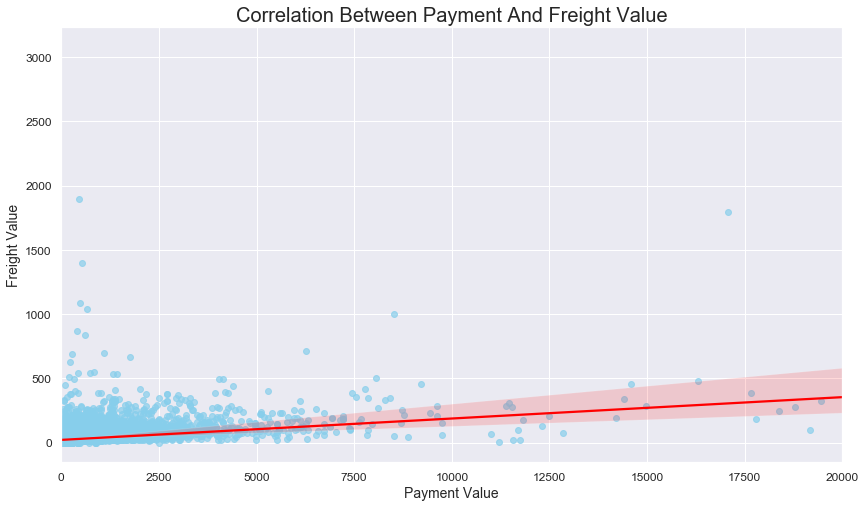

In [44]:
# plot Correlation between Payment and Freight value
plt.figure(figsize=(14,8))
sns.regplot(data=payment_vs_freight_df, x=payment_vs_freight_df.payment_value, y=payment_vs_freight_df.freight_value,
            scatter_kws={'alpha':0.7, 'color':'skyblue'}, line_kws={'color':'red'});
plt.xlim(0,20000);

plt.title('Correlation between Payment and Freight value'.title(), fontsize=20);
plt.ylabel('Freight value'.title(), fontsize=14);
plt.xlabel('Payment Value'.title(), fontsize=14);

plt.xticks(rotation=0, fontsize= 12);
plt.yticks(fontsize=12)
plt.show()

## Multivariable Plots
* Payment value vs. month vs. year
* we want to see the Evolution over time to understand better

In [45]:
master_df_with_product_categories['year'] = pd.DatetimeIndex(master_df_with_product_categories['order_purchase_timestamp']).year

In [46]:
master_df_with_product_categories['month'] = pd.DatetimeIndex(master_df_with_product_categories['order_purchase_timestamp']).month 

In [47]:
# extreme use of groupby to use later for stability 
master_df_with_product_categories.groupby(['year','month']).sum()['payment_value']

year  month
2016  9            347.52
      10         74677.62
      12            19.62
2017  1         185448.60
      2         333422.10
      3         520516.26
      4         494963.13
      5         716657.39
      6         597028.31
      7         736779.41
      8         870094.62
      9        1012532.44
      10       1006491.01
      11       1576858.43
      12       1026263.80
2018  1        1384836.09
      2        1304051.61
      3        1458087.36
      4        1488789.62
      5        1502407.34
      6        1295648.39
      7        1348025.26
      8        1226471.32
      9            166.46
Name: payment_value, dtype: float64

In [48]:
multivariable_plot_df = master_df_with_product_categories.groupby(['year','month']).sum()['payment_value'].reset_index()
multivariable_plot_df.head()


,year,month,payment_value
0,2016,9,347.52
1,2016,10,74677.62
2,2016,12,19.62
3,2017,1,185448.60
4,2017,2,333422.10


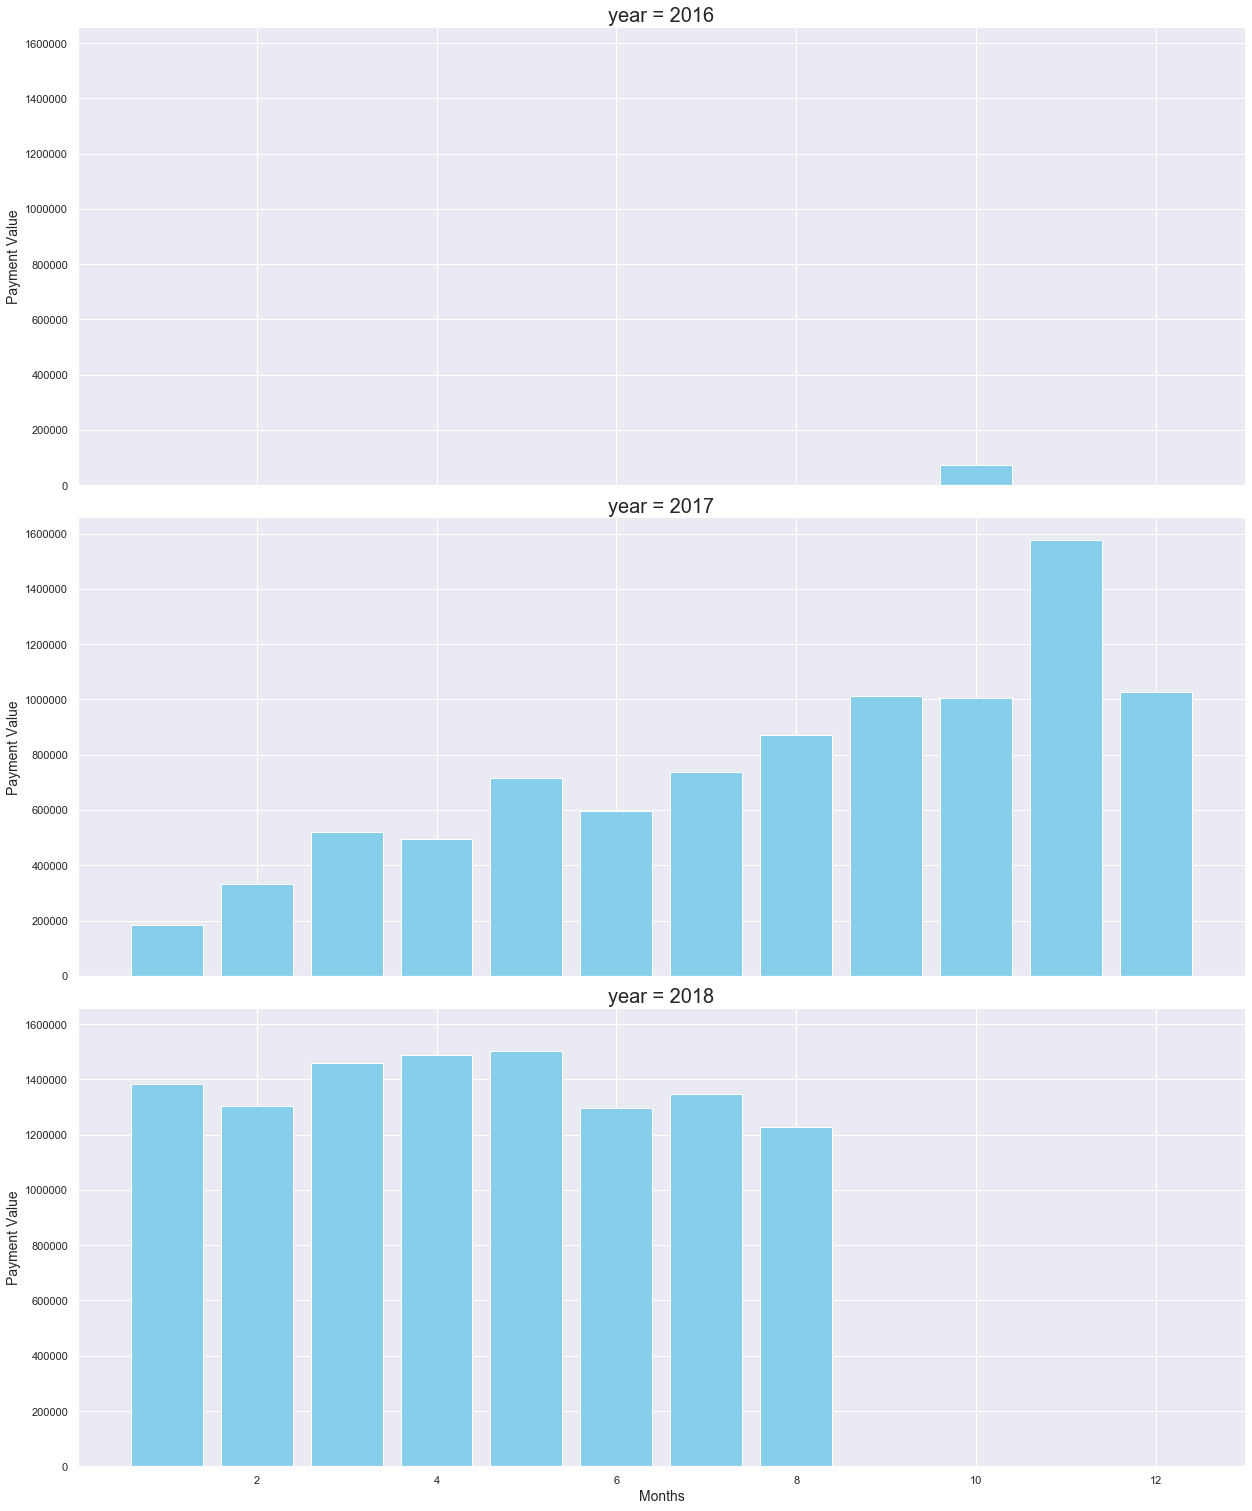

In [49]:
g = sns.FacetGrid(data=multivariable_plot_df, row = 'year', height=7, aspect=2.5, sharey=True)

g = g.map(plt.bar, 'month', 'payment_value', color='skyblue')
g.set_titles( size=20);
g.set_ylabels('Payment Value'.title(), size=14);
g.set_xlabels('months'.title(), size=14);



# Feature Engineering ( creation de nouvelles features pour aider l'algorithme de clustering ) 

In [50]:
master_df_with_product_categories['order_delivered_customer_date'].fillna(method='bfill',inplace=True)

## categorical features ----> numerical features using OHE

In [51]:

master_df1  = master_df_with_product_categories.copy()

catego_dummy_df = pd.get_dummies(master_df1['payment_type'],drop_first=True)
master_df1 = master_df1.merge(catego_dummy_df, on = master_df1.index)

In [52]:
# drop usless columns
master_df1.drop(['key_0','_merge'],axis=1,inplace=True)

In [53]:
# feature  : time it took to deliver 
master_df1['time_elapsed_delivery'] = master_df1['order_delivered_customer_date'] - master_df1['order_purchase_timestamp']
master_df1['time_elapsed_delivery'] = master_df1.time_elapsed_delivery.dt.days

## Recency

In [54]:
#creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(master_df1['customer_unique_id'])
df_user.columns = ['customer_unique_id']

#gets the max purchase date for each customer and create a dataframe with it
df_max_purchase = master_df1.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

#we take our observation point as the max purchase date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

df_user= df_user.groupby('customer_unique_id').mean().reset_index()

#merge it to master df
master_df1 = pd.merge(master_df1, df_user, on='customer_unique_id')
df_user.head()

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118
2,0000f46a3911fa3c0805444483337064,541
3,0000f6ccb0745a6a4b88665a16c9f078,325
4,0004aac84e0df4da2b147fca70cf8255,292


## Frequency 

In [55]:
#get order counts for each user and create a dataframe with it
df_frequency = master_df1.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
master_df1 = pd.merge(master_df1, df_frequency, on='customer_unique_id')
master_df1.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,year,month,credit_card,debit_card,voucher,time_elapsed_delivery,Recency,Frequency
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,1,credit_card,1,18.12,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares,2017,10,1,0,0,8,335,4
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,3,voucher,1,2.00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares,2017,10,0,0,1,8,335,4
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,2,voucher,1,18.59,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares,2017,10,0,0,1,8,335,4
3,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,493e9a0b23de35d37871a6e8940f822a,5,1,credit_card,1,44.11,1,9abb00920aae319ef9eba674b7d2e6ff,1771297ac436903d1dd6b0e9279aa505,2017-09-11 11:43:25,35.39,8.72,bebes,35.0,2395.0,1.0,350.0,19.0,14.0,12.0,7025,guarulhos,SP,baby,2017,9,1,0,0,1,335,4
4,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,b46f1e34512b0f4c74a72398b03ca788,4,1,credit_card,3,37.77,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares,2017,8,1,0,0,2,383,1


In [56]:
master_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116591 entries, 0 to 116590
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       116591 non-null  object        
 1   customer_id                    116591 non-null  object        
 2   order_status                   116591 non-null  object        
 3   order_purchase_timestamp       116591 non-null  datetime64[ns]
 4   order_approved_at              116591 non-null  datetime64[ns]
 5   order_delivered_carrier_date   115376 non-null  datetime64[ns]
 6   order_delivered_customer_date  116591 non-null  datetime64[ns]
 7   order_estimated_delivery_date  116591 non-null  datetime64[ns]
 8   customer_unique_id             116591 non-null  object        
 9   customer_zip_code_prefix       116591 non-null  int64         
 10  customer_city                  116591 non-null  object        
 11  

In [57]:
#save dataframe to csv for ML
master_df1.to_csv('data_cleaned.csv',index=False)

# Data ready for Machine Learning applications !